# Preprocessing

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from keras import Model

tf.__version__

'2.12.0'

In [78]:
SLICE_DURATION = 0.2
SAMPLING_RATE = 16000
N_FFT = 512
HOP_LENGTH = N_FFT // 4
MEL_BANDS=512
MEL_MIN_HZ = 50
MEL_MAX_HZ = SAMPLING_RATE / 2

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
N_KERNELS = 10
N_FILTERS = 1

N_EPOCHS = 25

In [79]:
window_length_samples = int(round(SAMPLING_RATE * SLICE_DURATION))
fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
hop_length = fft_length // 4

In [80]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [81]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [82]:
random_slice = slices[np.random.randint(len(slices))]

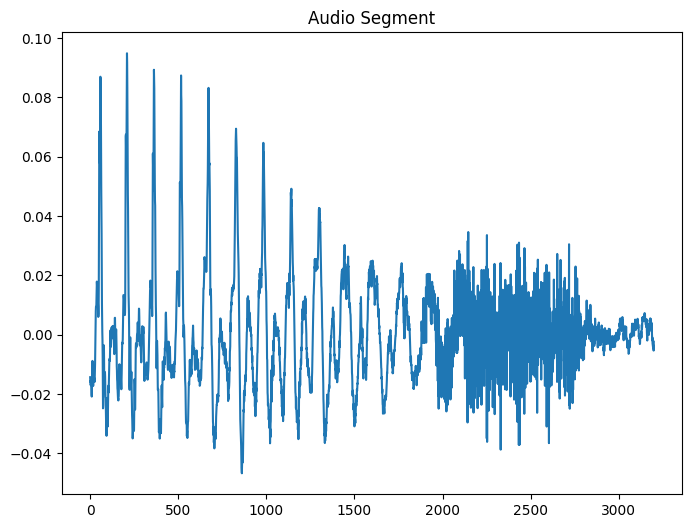

In [83]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [84]:
def get_stft(audio_slice):
    spectrogram = librosa.stft(audio_slice, n_fft=fft_length, hop_length=hop_length, win_length=fft_length)
    return abs(spectrogram)

In [85]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

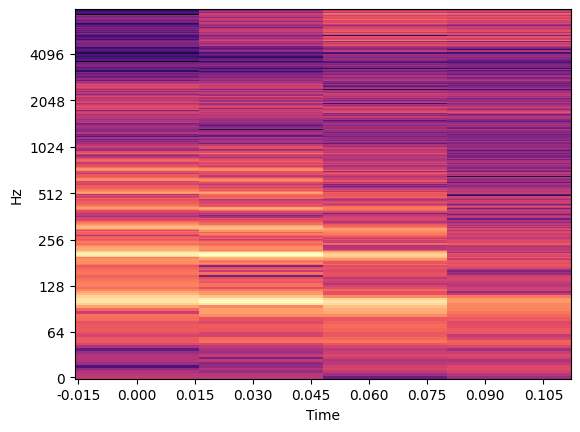

In [86]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [87]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [88]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((27, 2049, 4),
 array([[0.37512618, 0.23254499, 0.09703823, 0.07188381],
        [0.3537489 , 0.16196899, 0.05858192, 0.0713998 ],
        [0.32831305, 0.1334161 , 0.05846956, 0.05229666],
        ...,
        [0.00351448, 0.00449599, 0.00602721, 0.01540674],
        [0.00201224, 0.00142191, 0.00656772, 0.01605129],
        [0.0014697 , 0.00202157, 0.00971588, 0.01763892]], dtype=float32))

In [89]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(2049, 4)

# Create Train and Test Splits

In [90]:
male_voice_dir = "males"
female_voice_dir = "females"

In [91]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [92]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [93]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Models

## STFT Based Model

In [94]:
def audio_preprocess_stft(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_stfts, labels

In [95]:
def set_tensor_shapes_stft(slice_data, label):
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [96]:
train_dataset_stft = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_stft = train_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_stft = train_dataset_stft.map(set_tensor_shapes_stft)

train_dataset_stft = train_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [97]:
val_dataset_stft = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_stft = val_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_stft = val_dataset_stft.map(set_tensor_shapes_stft)

val_dataset_stft = val_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [98]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn_stft = Model(inputs, outputs)

In [99]:
model_cnn_stft.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [100]:
history_cnn_stft = model_cnn_stft.fit(train_dataset_stft,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_stft)

Epoch 1/25
1452/1452 [==============================] - 168s 54ms/step - loss: 0.5344 - accuracy: 0.7496 - val_loss: 0.5375 - val_accuracy: 0.7507
Epoch 2/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4713 - accuracy: 0.7873 - val_loss: 0.5149 - val_accuracy: 0.7710
Epoch 3/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4465 - accuracy: 0.7990 - val_loss: 0.4870 - val_accuracy: 0.7846
Epoch 4/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4323 - accuracy: 0.8054 - val_loss: 0.4689 - val_accuracy: 0.7927
Epoch 5/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4231 - accuracy: 0.8095 - val_loss: 0.4591 - val_accuracy: 0.7977
Epoch 6/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4176 - accuracy: 0.8119 - val_loss: 0.4516 - val_accuracy: 0.7999
Epoch 7/25
1452/1452 [==============================] - 22s 15ms/step - loss: 0.4143 - accuracy: 0.8131 - val_loss: 0.4465 

In [101]:
model_cnn_stft.evaluate(val_dataset_stft)

164/164 [==============================] - 1s 8ms/step - loss: 0.4283 - accuracy: 0.8088


[0.4283141493797302, 0.808756947517395]

## Mel Spectogram Based Model

In [102]:
mel_base = librosa.filters.mel(sr=SAMPLING_RATE, n_fft=fft_length, n_mels=MEL_BANDS, fmin=MEL_MIN_HZ, fmax=MEL_MAX_HZ, htk=True, norm=None)

In [103]:
def get_mel_spec(audio_slice):
    spectrogram = get_stft(audio_slice)
    magnitude_spectrogram = np.abs(spectrogram)
    mel = np.dot(mel_base, magnitude_spectrogram ** 2)
    return mel

In [104]:
def plot_mel_spec(mel_spec, sampling_rate=SAMPLING_RATE, f_max=MEL_MAX_HZ):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        spec_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=f_max,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

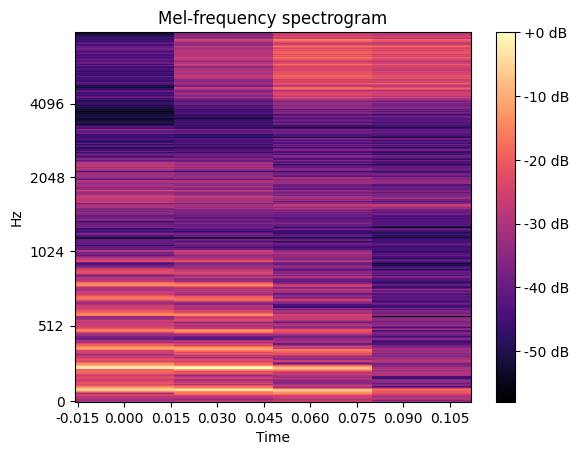

In [105]:
mel_spec = get_mel_spec(random_slice)
plot_mel_spec(mel_spec)

In [106]:
def get_audio_slices_mel_spec(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_mel_spec(audio_slice) for audio_slice in audio_slices])

In [107]:
mel_spec = get_audio_slices_mel_spec("males/0.wav")
mel_spec.shape, mel_spec[0]

((27, 512, 4),
 array([[2.6476187e-01, 1.1246436e-01, 4.0064776e-01, 5.0474429e-01],
        [1.0731848e-01, 9.5884509e-02, 3.6577985e-01, 2.7149341e-01],
        [1.3474168e-01, 3.4115294e-01, 4.3983674e-01, 6.7896962e-02],
        ...,
        [4.0069019e-05, 4.7536683e-05, 4.0167471e-04, 1.9956299e-03],
        [3.5226276e-05, 7.5423828e-05, 4.5912474e-04, 2.1287580e-03],
        [1.3763785e-04, 1.9361876e-04, 5.2465673e-04, 2.4703387e-03]],
       dtype=float32))

In [108]:
MEL_SPEC_SHAPE = mel_spec.shape[-2:]
MEL_SPEC_SHAPE

(512, 4)

In [109]:
def audio_preprocess_mel_spec(file_path, label):
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([tf.expand_dims(slice_mel_spec, -1) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [110]:
def set_tensor_shapes_mel_spec(slice_data, label):
    slice_data.set_shape(MEL_SPEC_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

In [111]:
train_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_mel_spec = train_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_mel_spec = train_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

train_dataset_mel_spec = train_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [112]:
val_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_mel_spec = val_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_mel_spec = val_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

val_dataset_mel_spec = val_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [113]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_mel_spec = Model(inputs, outputs)

In [114]:
model_cnn_mel_spec.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [115]:
history_cnn_mel_spec = model_cnn_mel_spec.fit(train_dataset_mel_spec,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_mel_spec)

Epoch 1/25
1452/1452 [==============================] - 375s 93ms/step - loss: 0.7256 - accuracy: 0.6553 - val_loss: 0.6677 - val_accuracy: 0.6427
Epoch 2/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.5285 - accuracy: 0.7459 - val_loss: 0.5171 - val_accuracy: 0.7307
Epoch 3/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.4622 - accuracy: 0.7818 - val_loss: 0.4767 - val_accuracy: 0.7738
Epoch 4/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.4401 - accuracy: 0.7958 - val_loss: 0.4819 - val_accuracy: 0.7772
Epoch 5/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.4304 - accuracy: 0.8033 - val_loss: 0.4690 - val_accuracy: 0.7830
Epoch 6/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.4222 - accuracy: 0.8069 - val_loss: 0.4637 - val_accuracy: 0.7861
Epoch 7/25
1452/1452 [==============================] - 17s 12ms/step - loss: 0.4191 - accuracy: 0.8090 - val_loss: 0.4781 

In [116]:
model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

164/164 [==============================] - 1s 4ms/step - loss: 0.4399 - accuracy: 0.8015


[0.4399080276489258, 0.8015151023864746]